## Standard Imports

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("../../../")
from matplotlib.animation import FuncAnimation
from polire.placement import NottDuns, Stationary

## Data Loading

In [28]:
train_data = pd.read_pickle('../dataset/PrecData_train.pickle')
test_data = pd.read_pickle('../dataset/PrecData_test.pickle')
G_train = pd.read_pickle('../dataset/PrecData_Gamma_train.csv')
G_test = pd.read_pickle('../dataset/PrecData_Gamma_test.csv')

train_data = train_data.reset_index(drop=True)
G_train = pd.DataFrame(G_train.values, index=range(G_train.shape[0]), columns=range(G_train.shape[0]))
G_test = pd.DataFrame(G_test.values, index=range(G_test.shape[0]), columns=range(G_test.shape[0]))

## Visualize all sensor locations in the 2D space

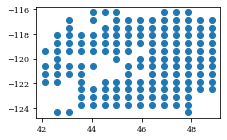

In [29]:
plt.scatter(train_data['lat'], train_data['lon'])

## Visualize train sensor locations in the 2D space

In [30]:
Seed = 42
train_sample = train_data.sample(30, random_state=Seed)
G = G_train.loc[train_sample.index, train_sample.index]
print(train_sample.shape, G.shape)

X_train = train_sample[['lat','lon']].values
y_train = train_sample[['data']].values.reshape(-1,1)

(30, 3) (30, 30)


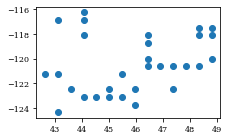

In [31]:
plt.scatter(train_sample['lat'], train_sample['lon'])

In [32]:
nonStat = NottDuns(N=10, eta=1)
nonStat.fit(X_train, y_train, G.values)

## Greedy algorithm for Near Optimal Sensor Placement!

In [33]:
# Initials
N = 30
Pilot_ind = train_sample.index.tolist()
A_ind_MI, _ = nonStat.place(train_data[['lat', 'lon']].values, Pilot_ind, N, 'MI')
A_ind_Var, _ = nonStat.place(train_data[['lat', 'lon']].values, Pilot_ind, N, 'Entropy')
MI = nonStat.MI
Var = nonStat.Var

## Visualizing sensor placements

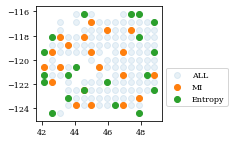

In [34]:
fig, ax = plt.subplots()
iteration = 20
ax.scatter(train_data.lat, train_data.lon, alpha=0.1, label='ALL')
ax.scatter(train_data.loc[A_ind_MI[:iteration]]['lat'], train_data.loc[A_ind_MI[:iteration]]['lon'], label='MI')
ax.scatter(train_data.loc[A_ind_Var[:iteration]]['lat'], train_data.loc[A_ind_Var[:iteration]]['lon'], label='Entropy')
ax.legend(bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.show()

## RMSE Plot

In [35]:
Eta = 100
NN = lambda x: len(x)//2
Pilot_ind = []
MI_rms = np.zeros((len(MI), len(test_data.index.unique()[::8])))
Var_rms = np.zeros((len(Var), len(test_data.index.unique()[::8])))
for iter_i, epoch_id in enumerate(test_data.index.unique()[::8]):
    for sens_i in range(len(MI)):
        clear_output(wait=True)
        print(iter_i, sens_i)
        test_tmp = test_data.loc[epoch_id].set_index('lat-lon').reset_index(drop=True)
        # Predict and save RMSE
        
        # For Variance based locations ------------------

        GP_train_X = test_tmp.loc[A_ind_Var[:sens_i]+Pilot_ind][['lat','lon']].values
        GP_train_Y = test_tmp.loc[A_ind_Var[:sens_i]+Pilot_ind][['data']].values
        GP_test_X = test_tmp.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0)[['lat','lon']].values
        GP_test_Y = test_tmp.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0)[['data']].values
        GP_Gamma = G_test.loc[A_ind_Var[:sens_i]+Pilot_ind, A_ind_Var[:sens_i]+Pilot_ind].values
        
        m = NottDuns(NN(GP_train_X), Eta, 'm32')
        m.fit(GP_train_X, GP_train_Y, GP_Gamma)
        GP_predict_Y = m.predict(GP_test_X)
        #GP_predict_Y = 18 + cov_func(GP_test_X, GP_train_X).dot(np.linalg.pinv(cov_func(GP_train_X, GP_train_X))).dot(GP_train_Y - GP_train_Y.mean())
        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        Var_rms[sens_i, iter_i] = rms
        
        # For MI based locations ------------------
        GP_train_X = test_tmp.loc[A_ind_MI[:sens_i]+Pilot_ind][['lat','lon']].values 
        GP_train_Y = test_tmp.loc[A_ind_MI[:sens_i]+Pilot_ind][['data']].values
        GP_test_X = test_tmp.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0)[['lat','lon']].values
        GP_test_Y = test_tmp.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0)[['data']].values
        GP_Gamma = G_test.loc[A_ind_MI[:sens_i]+Pilot_ind, A_ind_MI[:sens_i]+Pilot_ind].values
        m = NottDuns(NN(GP_train_X), Eta, 'm32')
        m.fit(GP_train_X, GP_train_Y, GP_Gamma)
        GP_predict_Y = m.predict(GP_test_X)
        #GP_predict_Y = 18 + cov_func(GP_test_X, GP_train_X).dot(np.linalg.pinv(cov_func(GP_train_X, GP_train_X))).dot(GP_train_Y - GP_train_Y.mean())
        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        MI_rms[sens_i, iter_i] = rms

5 29


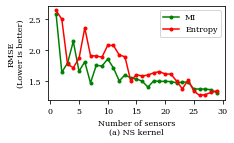

In [36]:
MM = 3

MI_rms_mean_NS = MI_rms[:,0]#.mean(axis=1)
Var_rms_mean_NS = Var_rms[:,0]#.mean(axis=1)

fig, ax = plt.subplots()
tmp = ax.plot(range(len(MI_rms_mean_NS)), MI_rms_mean_NS, 'go-', label='MI', markersize=MM)

tmp = ax.plot(range(len(Var_rms_mean_NS)), Var_rms_mean_NS, 'ro-', label='Entropy', markersize=MM)
ax.set_xlabel('Number of sensors\n(a) NS kernel')
ax.set_ylabel('RMSE\n(Lower is better)')
ax.legend()
plt.tight_layout()
plt.show()

## Learning stationary kernel

In [37]:
Seed = 42
train_sample = train_data.sample(30, random_state=Seed)
G = G_train.loc[train_sample.index, train_sample.index]
print(train_sample.shape, G.shape)

X_train = train_sample[['lat','lon']].values
y_train = train_sample[['data']].values.reshape(-1,1)


Stat = Stationary(n_restarts=1, kernel_name='m32')
Stat.fit(X_train, y_train)

(30, 3) (30, 30)
Optimization restart 1/1, f = 64.75646983652577


## Greedy placement

In [38]:
N = 30
Pilot_ind = train_sample.index.tolist()
A_ind_MI, _ = Stat.place(train_data[['lat', 'lon']].values, Pilot_ind, N, 'MI')
A_ind_Var, _ = Stat.place(train_data[['lat', 'lon']].values, Pilot_ind, N, 'Entropy')
MI = Stat.MI
Var = Stat.Var

## RMSE plot

In [39]:
Gran = 8
MI_rms1 = np.zeros((len(MI), len(test_data.index.unique()[::Gran])))
Var_rms1 = np.zeros((len(Var), len(test_data.index.unique()[::Gran])))
for iter_i, epoch_id in enumerate(test_data.index.unique()[::Gran]):
    for sens_i in range(len(MI)):
        clear_output(wait=True)
        print(iter_i, sens_i)
        test_tmp = test_data.loc[epoch_id].set_index('lat-lon').reset_index(drop=True)
        # Predict and save RMSE
        
        # For Variance based locations ------------------

        GP_train_X = test_tmp.loc[A_ind_Var[:sens_i]+Pilot_ind][['lat','lon']].values
        GP_train_Y = test_tmp.loc[A_ind_Var[:sens_i]+Pilot_ind]['data'].values.reshape(-1,1)
        GP_test_X = test_tmp.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0)[['lat','lon']].values
        GP_test_Y = test_tmp.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0)['data'].values.reshape(-1,1)

        Stat = Stationary(1, 'm32', True)
        Stat.fit(GP_train_X, GP_train_Y)
        GP_predict_Y = Stat.predict(GP_test_X)
        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        Var_rms1[sens_i, iter_i] = rms
        
        # For MI based locations ------------------
        GP_train_X = test_tmp.loc[A_ind_MI[:sens_i]+Pilot_ind][['lat','lon']].values 
        GP_train_Y = test_tmp.loc[A_ind_MI[:sens_i]+Pilot_ind]['data'].values.reshape(-1,1)
        GP_test_X = test_tmp.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0)[['lat','lon']].values
        GP_test_Y = test_tmp.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0)['data'].values.reshape(-1,1)

        Stat = Stationary(1, 'm32', True)
        Stat.fit(GP_train_X, GP_train_Y)
        GP_predict_Y = Stat.predict(GP_test_X)

        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        MI_rms1[sens_i, iter_i] = rms

5 29
Optimization restart 1/1, f = 153.39097691420446
Optimization restart 1/1, f = 133.19868986208542


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': False,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

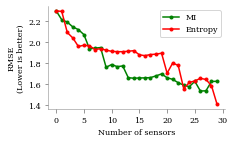

In [41]:
MM = 3
MI_rms_mean = MI_rms1.mean(axis=1)
Var_rms_mean = Var_rms1.mean(axis=1)
latexify(3.3)
fig, ax = plt.subplots()
format_axes(ax)
tmp = ax.plot(range(len(MI_rms_mean)), MI_rms_mean, 'go-', label='MI', markersize=MM)
tmp = ax.plot(range(len(Var_rms_mean)), Var_rms_mean, 'ro-', label='Entropy', markersize=MM)
ax.set_xlabel('Number of sensors')
ax.set_ylabel('RMSE\n(Lower is better)')
ax.legend()
plt.tight_layout()
plt.savefig('/home/anaconda/patel_zeel/figure10.pdf')
plt.show()

## Appendix

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': False,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

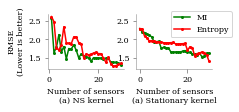

In [71]:
latexify(3.3, 1.5)
MM = 2

fig, ax = plt.subplots(1, 2, sharey=True)
tmp = ax[0].plot(range(len(MI_rms_mean_NS)), MI_rms_mean_NS, 'go-', label='MI', markersize=MM)

tmp = ax[0].plot(range(len(Var_rms_mean_NS)), Var_rms_mean_NS, 'ro-', label='Entropy', markersize=MM)
ax[0].set_xlabel('Number of sensors\n(a) NS kernel')
ax[0].set_ylabel('RMSE\n(Lower is better)')
#ax[0].legend()

tmp = ax[1].plot(range(len(MI_rms_mean)), MI_rms_mean, 'go-', label='MI', markersize=MM)
tmp = ax[1].plot(range(len(Var_rms_mean)), Var_rms_mean, 'ro-', label='Entropy', markersize=MM)
ax[1].set_xlabel('Number of sensors\n(a) Stationary kernel')
#ax[1].set_ylabel('RMSE\n(Lower is better)')
ax[1].legend(bbox_to_anchor=(0.4,0.5))
plt.tight_layout()
format_axes(ax[0])
format_axes(ax[1])
plt.savefig('/home/anaconda/patel_zeel/figure10.pdf')
plt.show()